In [2]:
"""
Implementation of the Social Aware Assignment of Passengers in Ridesharing
Which was described in the article:
Levinger, C., Hazon, N., & Azaria, A. (2022). Social Aware Assignment of Passengers in Ridesharing.
In Proceedings of the 2022 ACM Conference on Economics and Computation (EC 2022).
Short version: http://azariaa.com/Content/Publications/Social_Assignment_SA.pdf
Full version: https://github.com/VictoKu1/ResearchAlgorithmsCourse1/blob/main/Article/2022%2C%20Chaya%20Amos%20Noam%2C%20Socially%20aware%20assignment%20of%20passengers%20in%20ride%20sharing.pdf

Paper ID: 1862

Implementation of match_and_merge
algorithm is based on the pseudocode from the article
which is written by Victor Kushnir.
"""
import networkx as nx

def match_and_merge(G: nx.Graph, k: int) -> list:
    """
    An approximation algorithm for any k ≥ 3, provides a solution for the social aware assignment problem with a ratio of 1/(k-1).

    As described in the article under the section "Algorithm 1: Match and Merge".

    Function receives a graph G and a number k, and returns a partition P of G of all matched sets.

    The algorithm consists of k - 1 rounds. Each round is composed of a matching phase followed by a merging phase.
    Specifically, in round l MnM computes a maximum matching, M_l ⊆ E_l , for G_l (where G_1 = G). In the merging phase, MnM creates a graph
    G_(l+1) that includes a unified node for each pair of matched nodes. G_(l+1) also includes all unmatched nodes, along with their
    edges to the unified nodes. Clearly, each node in V_l is composed of up-to l nodes
    from V_1. Finally, MnM returns the partition, P, of all the matched sets.

    :param G: Graph
    :param k: Number of passengers
    :return: A partition P of G of all matched sets
    
    Example where G={(v1,v2),(v2,v3),(v3,v4),(v4,v5),(v4,v6)} and k=4:
    >>> G = nx.Graph()
    >>> list_of_edges = [(1, 2), (2, 3), (3, 4), (4, 5), (4, 6)]
    >>> G.add_edges_from(list_of_edges)
    >>> k = 4
    >>> print(match_and_merge(G, k))
    [[1, 2], [3, 4, 5, 6]]
    """
    # Check if k is correct
    if G.number_of_nodes() < k:
        raise nx.NetworkXError("k cannot be greater than the number of nodes in the graph G")
    # If k is negative, raise an error
    elif k < 0:
        raise nx.NetworkXError("k should be 0≤k≤|V(G)|")
    # If k is 0, return an empty list
    elif k == 0:
        return []
    # If k is 1, return a partition of G where each node is a list
    elif k == 1:
        return [[node] for node in G.nodes()]
    # If k is 2, run the maximum matching algorithm on G and return the result
    elif k == 2:
        return [list(partition) for partition in nx.maximal_matching(G)]
    else:
        # Implement G_l=(V_l,E_l) using a dictionary which contains a tuple of V_l and E_l
        G = {1: G}
        # Should contain the maximal matching of G_l
        M = {}
        # Loop to find the lth maximal matching and put it in G_(l+1)
        for l in range(1, k):
            # Initialization of the unified nodes list
            unified_nodes = []
            # Find the maximal matching of G_l
            M[l] = list(nx.maximal_matching(G[l]))
            # Make sure that G_(l+1) is a empty graph (It was one of the steps of the algorithm in the article)
            G[l+1] = nx.Graph()
            # Put the nodes of G_l in G_(l+1)
            G[l+1].add_nodes_from(tuple(G[l].nodes()))
            # For every match in M_l, add a unified node to G_(l+1) so it will be used to find it when needed
            for match in M[l]:
                # Add the match to the unified nodes dictionary, so it will be easier to find the unified nodes in each round
                unified_nodes.append(match)
                # Add a unified node to G_(l+1), which is a tuple of the nodes in the match
                G[l+1].add_node(match)
                # Remove the nodes in the match from G_(l+1)
                G[l+1].remove_nodes_from(list(match))
            # For every unified node in G_(l+1), add every v_q in G_(l+1) that is connected to it in G_l, add an edge between them in G_(l+1)
            for unified_node in unified_nodes:
                for v_q in G[l+1].nodes():
                    if unified_node != v_q and any(specific_node != v_q and G[l].has_edge(specific_node, v_q) for specific_node in unified_node):
                        if not isinstance(v_q, tuple):
                            if v_q in unified_node:
                                continue
                            else:
                                G[l+1].add_edge(unified_node, v_q)
                        elif all(specific_node in unified_node for specific_node in v_q) or all(specific_node in v_q for specific_node in unified_node):
                            continue
                        else:
                            G[l+1].add_edge(unified_node, v_q)
        # Initialization of the partition P and for every unified node (which is a tuple of nodes) in G_k, add it to P
        P = [[unified_node] for unified_node in G[k].nodes()]
        # For every partition in P, remove all inner tuple brackets
        for partition in P:
            while any(isinstance(node, tuple) for node in partition):
                for node in partition:
                    if isinstance(node, tuple):
                        partition.remove(node)
                        partition.extend(list(node))
            partition.sort()
        # For every partition in P, sort it
        P.sort()
    # Return P
    return P

In [3]:
# Improvement of match_and_merge algorithm runtime using threading
import threading
def match_and_merge_threading(G: nx.Graph, k: int) -> list:
    # Check if k is correct
    if G.number_of_nodes() < k:
        raise nx.NetworkXError("k cannot be greater than the number of nodes in the graph G")
    # If k is negative, raise an error
    elif k < 0:
        raise nx.NetworkXError("k should be 0≤k≤|V(G)|")
    # If k is 0, return an empty list
    elif k == 0:
        return []
    # If k is 1, return a partition of G where each node is a list
    elif k == 1:
        return [[node] for node in G.nodes()]
    # If k is 2, run the maximum matching algorithm on G and return the result
    elif k == 2:
        return [list(partition) for partition in nx.maximal_matching(G)]
    else:
        # Implement G_l=(V_l,E_l) using a dictionary which contains a tuple of V_l and E_l
        G = {1: G}
        # Should contain the maximal matching of G_l
        M = {}
        # Loop to find the lth maximal matching and put it in G_(l+1)
        for l in range(1, k):
            # Initialization of the unified nodes list
            unified_nodes = []
            # Find the maximal matching of G_l
            t1 = threading.Thread(target=nx.maximal_matching, args=(G[l],))
            t1.start()
            M[l] = list(nx.maximal_matching(G[l]))
            t1.join()
            # Make sure that G_(l+1) is a empty graph (It was one of the steps of the algorithm in the article)
            G[l+1] = nx.Graph()
            # Put the nodes of G_l in G_(l+1)
            G[l+1].add_nodes_from(tuple(G[l].nodes()))
            # For every match in M_l, add a unified node to G_(l+1) so it will be used to find it when needed
            for match in M[l]:
                # Add the match to the unified nodes dictionary, so it will be easier to find the unified nodes in each round
                unified_nodes.append(match)
                # Add a unified node to G_(l+1), which is a tuple of the nodes in the match
                G[l+1].add_node(match)
                # Remove the nodes in the match from G_(l+1)
                G[l+1].remove_nodes_from(list(match))
            # For every unified node in G_(l+1), add every v_q in G_(l+1) that is connected to it in G_l, add an edge between them in G_(l+1)
            for unified_node in unified_nodes:
                for v_q in G[l+1].nodes():
                    if unified_node != v_q and any(specific_node != v_q and G[l].has_edge(specific_node, v_q) for specific_node in unified_node):
                        if not isinstance(v_q, tuple):
                            if v_q in unified_node:
                                continue
                            else:
                                G[l+1].add_edge(unified_node, v_q)
                        elif all(specific_node in unified_node for specific_node in v_q) or all(specific_node in v_q for specific_node in unified_node):
                            continue
                        else:
                            G[l+1].add_edge(unified_node, v_q)
        # Initialization of the partition P and for every unified node (which is a tuple of nodes) in G_k, add it to P
        P = [[unified_node] for unified_node in G[k].nodes()]
        # For every partition in P, remove all inner tuple brackets using threading
        class RemoveTupleBrackets(threading.Thread):
            def __init__(self, partition):
                threading.Thread.__init__(self)
                self.partition = partition
            def run(self):
                while any(isinstance(node, tuple) for node in self.partition):
                    for node in self.partition:
                        if isinstance(node, tuple):
                            self.partition.remove(node)
                            self.partition.extend(list(node))
                self.partition.sort()
        threads = []
        for partition in P:
            thread = RemoveTupleBrackets(partition)
            thread.start()
            threads.append(thread)
        for thread in threads:
            thread.join()
        # For every partition in P, sort it
        P.sort()
    # Return P
    return P

In [4]:
import cython

In [5]:
%load_ext Cython

In [6]:
%%cython
def match_and_merge_cython(G, k):
    import networkx as nx
    # Check if k is correct
    if G.number_of_nodes() < k:
        raise nx.NetworkXError("k cannot be greater than the number of nodes in the graph G")
    # If k is negative, raise an error
    elif k < 0:
        raise nx.NetworkXError("k should be 0≤k≤|V(G)|")
    # If k is 0, return an empty list
    elif k == 0:
        return []
    # If k is 1, return a partition of G where each node is a list
    elif k == 1:
        return [[node] for node in G.nodes()]
    # If k is 2, run the maximum matching algorithm on G and return the result
    elif k == 2:
        return [list(partition) for partition in nx.maximal_matching(G)]
    else:
        # Implement G_l=(V_l,E_l) using a dictionary which contains a tuple of V_l and E_l
        G = {1: G}
        # Should contain the maximal matching of G_l
        M = {}
        # Loop to find the lth maximal matching and put it in G_(l+1)
        for l in range(1, k):
            # Initialization of the unified nodes list
            unified_nodes = []
            # Find the maximal matching of G_l
            M[l] = list(nx.maximal_matching(G[l]))
            # Make sure that G_(l+1) is a empty graph (It was one of the steps of the algorithm in the article)
            G[l+1] = nx.Graph()
            # Put the nodes of G_l in G_(l+1)
            G[l+1].add_nodes_from(tuple(G[l].nodes()))
            # For every match in M_l, add a unified node to G_(l+1) so it will be used to find it when needed
            for match in M[l]:
                # Add the match to the unified nodes dictionary, so it will be easier to find the unified nodes in each round
                unified_nodes.append(match)
                # Add a unified node to G_(l+1), which is a tuple of the nodes in the match
                G[l+1].add_node(match)
                # Remove the nodes in the match from G_(l+1)
                G[l+1].remove_nodes_from(list(match))
            # For every unified node in G_(l+1), add every v_q in G_(l+1) that is connected to it in G_l, add an edge between them in G_(l+1)
            for unified_node in unified_nodes:
                for v_q in G[l+1].nodes():
                    if unified_node != v_q and any(specific_node != v_q and G[l].has_edge(specific_node, v_q) for specific_node in unified_node):
                        if not isinstance(v_q, tuple):
                            if v_q in unified_node:
                                continue
                            else:
                                G[l+1].add_edge(unified_node, v_q)
                        elif all(specific_node in unified_node for specific_node in v_q) or all(specific_node in v_q for specific_node in unified_node):
                            continue
                        else:
                            G[l+1].add_edge(unified_node, v_q)
        # Initialization of the partition P and for every unified node (which is a tuple of nodes) in G_k, add it to P
        P = [[unified_node] for unified_node in G[k].nodes()]
        # For every partition in P, remove all inner tuple brackets
        for partition in P:
            while any(isinstance(node, tuple) for node in partition):
                for node in partition:
                    if isinstance(node, tuple):
                        partition.remove(node)
                        partition.extend(list(node))
            partition.sort()
        # For every partition in P, sort it
        P.sort()
    # Return P
    return P

In [7]:
# Comparison of the runtimes of the algorithms
import time
results = []
results_answer = []
cython_results = []
cython_results_answer = []
threading_results = []
threading_results_answer = []
for k in range(2,25):
    for v in range(k, 100):
        for p in range(v, 100):
            G = nx.gnm_random_graph(v, p)
            start_time = time.time()
            results_answer.append(len(match_and_merge(G, k)))
            results.append(time.time() - start_time)
            start_time = time.time()
            threading_results_answer.append(len(match_and_merge_threading(G, k)))
            threading_results.append(time.time() - start_time)
            start_time = time.time()
            cython_results_answer.append(len(match_and_merge_cython(G, k)))
            cython_results.append(time.time() - start_time)

Runtime:


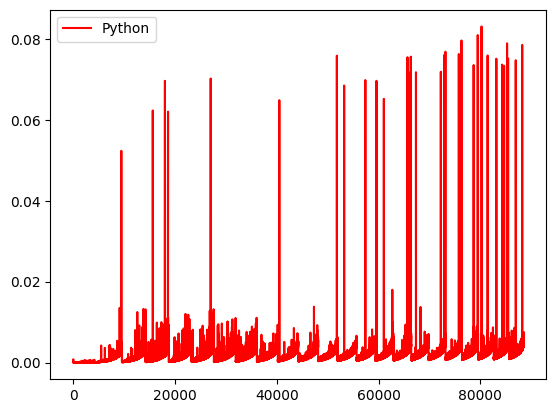

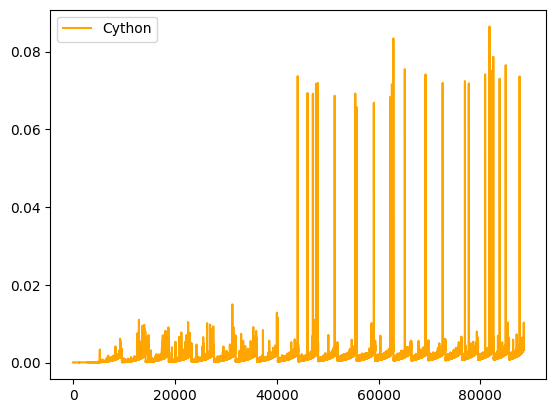

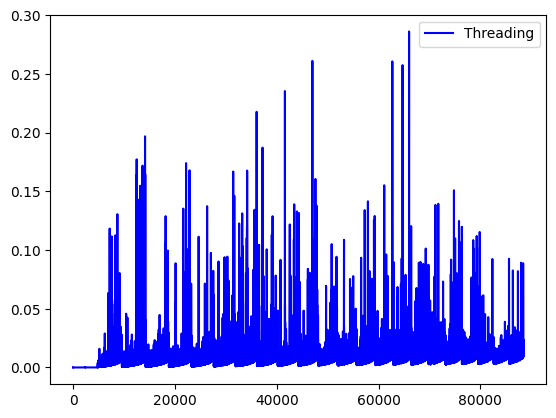

Answer:


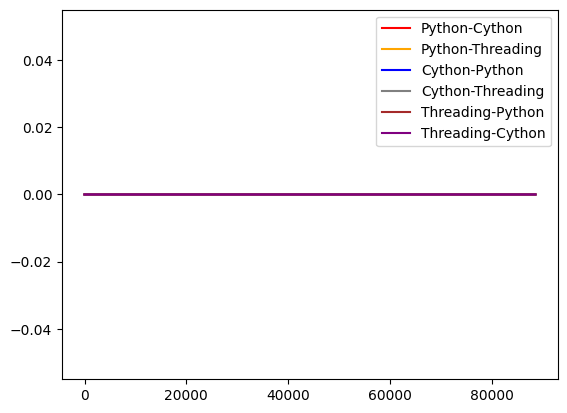

In [9]:
from matplotlib import pyplot as plt

names = ["Python", "Cython", "Threading"]
colors = ["red", "orange", "blue", "grey", "brown", "purple"]
info = [results, cython_results, threading_results]
answer = [results_answer, cython_results_answer, threading_results_answer]

print("Runtime:")

for i in range(3):
    plt.plot(info[i], label=names[i], color=colors[i])
    plt.legend()
    plt.show()

print("Answer:")

c=0
for i in range(3):
    for j in range(3):
        if i!=j:
            plt.plot([abs(answer[i][k]-answer[j][k]) for k in range(len(answer[i]))], label=names[i]+"-"+names[j], color=colors[c])
            c+=1
plt.legend()
plt.show()


